# Predict viral tweets

In [2]:
SEED = 26062019

test_size = 0.5 

import sys
sys.path.append('/exports/reum/tdmaarseveen/modules')
#import scipy
import numpy as np
import pandas as pd
from sklearn import __version__ as sk_vers
import matplotlib.pyplot as plt
from matplotlib import __version__ as m_vers

#import pickle
#from yellowbrick import __version__ as yb_vers
#import NLP_functions as func
#from pattern import __version__ as pat_vers
#import random
#from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
#import sklearn.ensemble as ske
#import re
#import xgboost as xgb
#import seaborn as sns


print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)

Current versions Modules:

Pandas version:		0.24.2
Matplotlib version:	3.1.0
numpy version:		1.16.4
sklearn version:	0.21.2


## Load data

In [4]:
df_tweets = pd.read_csv(r'input/trumptweets.csv', sep=',')
print('nr of tweets: ', len(df_tweets))
df_tweets.head()

nr of tweets:  41122


,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273,NaN,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18,NaN,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24,NaN,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965,NaN,NaN,NaN


In [5]:
print('First tweet: ', df_tweets['date'].min())
print('Final tweet: ', df_tweets['date'].max())

First tweet:  2009-05-04 20:54:25
Final tweet:  2020-01-20 02:57:49


## Most popular tweet

In [9]:
df_tweets[df_tweets['favorites']==df_tweets['favorites'].max()]

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
38625,1157345692517634049,https://twitter.com/realDonaldTrump/status/115...,A$AP Rocky released from prison and on his way...,2019-08-02 19:41:30,240363,857678,NaN,NaN,NaN


In [17]:
df_tweets[df_tweets['retweets']==df_tweets['retweets'].max()]

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
32059,881503147168071680,https://twitter.com/realDonaldTrump/status/881...,# FraudNewsCNN # FNNpic.twitter.com/WYUnHjjUjg,2017-07-02 15:21:42,309892,528265,NaN,# #,NaN


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import DispersionPlot

def plotLexicalDispersion(X, nr_features, title, **kwargs):
    """
    Draws a lexical dispersion plot which visualizes 
    the homogeneity across the corpus. 
    
    Also confirms wheter or not the data is randomized, 
    and visualizes the prevalence of features.
    
    Input:
        X = array with text data (EHR entries)
        nr_features = top n number of features to plot
        n_grams = chunksize for text processing :
            Note: chunksize refers to nr of words / not nr of 
                characters!
        kwargs = arguments for feature vectorizer (TfidfVectorizer):
            ngram_range = specifies the range of the ngram features
    """
    count = 0
    d = {}
    words = []
    for x in X:
        if kwargs['ngram_range'][1] != 1:
            l = [i for i in x.split(' ')]
            words.append([' '.join(l[i: i+(kwargs['ngram_range'][1])]) for i in range(len(l)) if len(l[i: i+(kwargs['ngram_range'][0])]) <= (kwargs['ngram_range'][1])])
            if len(words[-1]) == 0:
                del words[-1]
        else :
            words.append([i for i in x.split(' ')])
        count+=1
    #words.append([i for i in x.split(' ')])
    d = np.array(words)
    count_vect = TfidfVectorizer(ngram_range=kwargs['ngram_range'])
    
    X_train_tfidf = count_vect.fit_transform(X) 
    X_pd = pd.DataFrame(X_train_tfidf.toarray(), columns=count_vect.get_feature_names())
    print(X_pd.columns)
    feature_to_plot =list(X_pd.sum().sort_values(ascending=False).keys()[:nr_features]) 
    visualizer = DispersionPlot(feature_to_plot, size=(450, 450))
    ax = visualizer.ax
    ax.tick_params(labelsize=18)
    visualizer.fit(d)
    visualizer.poof()
    return

In [25]:
" ".join(list(df_tweets['content'].head(5).str.lower()))

'be sure to tune in and watch donald trump on late night with david letterman as he presents the top ten list tonight! donald trump will be appearing on the view tomorrow morning to discuss celebrity apprentice and his new book think like a champion! donald trump reads top ten financial tips on late show with david letterman: http://tinyurl.com/ooafwn - very funny! new blog post: celebrity apprentice finale and lessons learned along the way: http://tinyurl.com/qlux5e "my persona will never be that of a wallflower - i’d rather build walls than cling to them" --donald j. trump'

In [46]:
import re

def simpleCleaning(sentence):
    sticky_chars = r'([!#,.:";@\-\+\\/&=$\]\[<>\'^\*`â€™\(\)\d])'
    sentence = re.sub(sticky_chars, r' ', sentence)
    sentence = sentence.lower()
    return sentence

# convert to lowercase
df_tweets['content'] = df_tweets['content'].str.lower()
# remove links
df_tweets['content'] = df_tweets['content'].str.replace('http\S+|www.\S+', '', case=False)
# simple cleaning
df_tweets['content'] = df_tweets['content'].apply(lambda x : simpleCleaning(x))

Index(['abandon terror', 'able to', 'abortion socialism', 'about all',
       'about as', 'about convicting', 'about country', 'about impeachment',
       'about is', 'about me',
       ...
       'که آمریکا', 'که ایران', 'که بیش', 'گر است', 'گر این', 'گروه های',
       'گزارش بدهند', 'یا قطع', 'یا نه', 'یابند رهبران'],
      dtype='object', length=8688)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


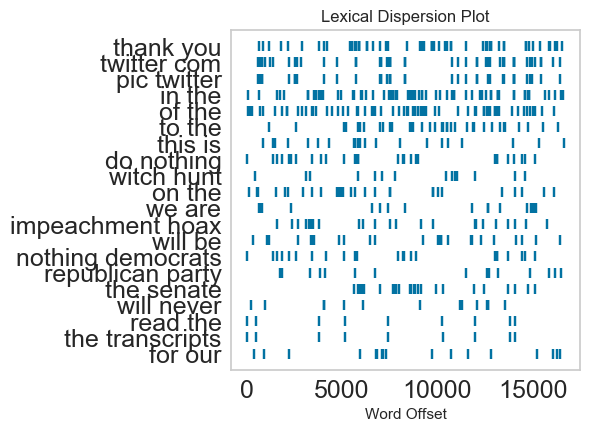

In [55]:
title ='Lexical Dispersion Plot of most popular chunks (n=2) in last 500 Trump tweets'
plotLexicalDispersion(df_tweets['content'].tail(500), nr_features=20, title=title, ngram_range=(2,2))

Index(['aaa traffic', 'aakbunw ro', 'abandon terror', 'abandon the',
       'abandon their', 'abandoned as', 'abandoned by',
       'abandoned republicans', 'abandoned the', 'abandoned you',
       ...
       'که ایران', 'که بیش', 'که مدتهاست', 'گر است', 'گر این', 'گروه های',
       'گزارش بدهند', 'یا قطع', 'یا نه', 'یابند رهبران'],
      dtype='object', length=109880)


C:\Users\levrex\Anaconda3\lib\site-packages\yellowbrick\text\dispersion.py:173: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_target = np.stack(self._compute_dispersion(X, y))
C:\Users\levrex\Anaconda3\lib\site-packages\yellowbrick\text\dispersion.py:177: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  zip(points_target[:, 0].astype(int), points_target[:, 1].astype(int))
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points

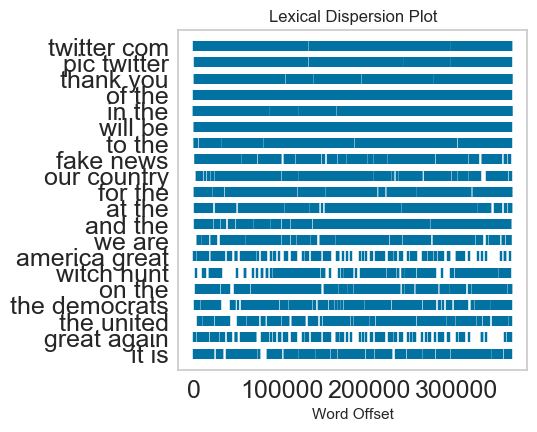

In [62]:
title ='Lexical Dispersion Plot of most popular chunks (n=2) in last 500 Trump tweets'
plotLexicalDispersion(df_tweets['content'].tail(10000), nr_features=20, title=title, ngram_range=(2,2))

In [ ]:
from yellowbrick.target import FeatureCorrelation
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

def plotFeatureChiSquared(X_train_fold, y_train_fold, nr_features, **kwargs):
    """
    Draw a chi squared plot for the top n features
    
    Input:
        X_train_fold = array with text data (EHR entries) from
            trainingsset
        y_train_fold = labels of the trainingsset
        nr_features = specifies the nr of features to draw 
            (descending order)
        n_grams = chunk text on n_grams / motifs rather than
            on whitespace
        kwargs = arguments for feature vectorizer (TfidfVectorizer):
            ngram_range = specifies the range of the ngram features
    Output:
        plt = matplotlib pyplot showcasing the correlation for
            each of the most occurring features
    """
    tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
    x_train_tfidf = tvec.fit_transform(X_train_fold)
    chi2score = chi2(x_train_tfidf, y_train_fold)[0]
    
    plt.figure(figsize=(15 ,10+ 6*(nr_features/20)))
    wscores = zip(tvec.get_feature_names(), chi2score)
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = list(zip(*wchi2[-nr_features:]))
    
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.barh(x ,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x , '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels, fontsize=18)
    plt.xticks(fontsize=16)
    plt.xlabel('$\chi^2$', fontsize=18)
    plt.title('Chi-squared test of top ' + str(nr_features) + 
                  ' features', fontsize=20, fontweight='bold')
    return plt

X = df_tweets['content'].tail(10000)
y = df_tweets['retweets'].tail(10000)


plotFeatureChiSquared(X, y, nr_features=20, ngram_range=(1,3))
#locs, labels = plt.yticks()  

#plt.yticks(locs, ['ra', 'erosive', 'active', 'not-active', 'on', 'rf',  'currently', 'not', 'remission', 'in', 'the', 'with', 'and', 'no', 'arthrosis', 'in case of/by', 'polyarthritis', 'of/from', 'arthritis', 'dd'][::-1])
#plt.show()

ValueError: dimension mismatch

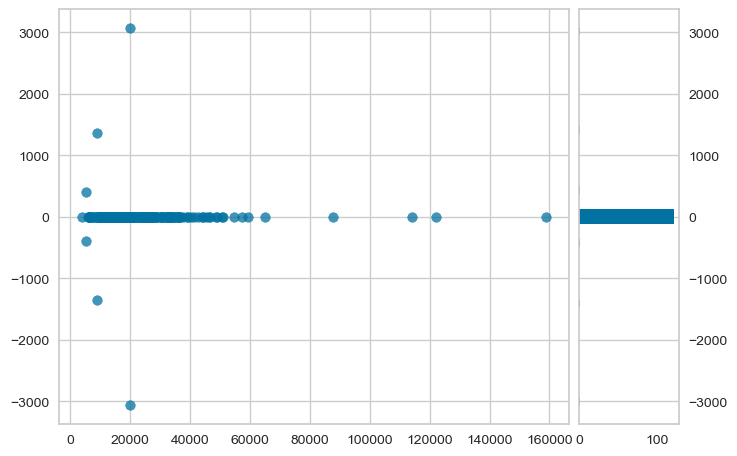

In [60]:
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df_tweets['content'].tail(500)
y = df_tweets['retweets'].tail(500)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5
)
count_vect = TfidfVectorizer()
X_train_tfidf = count_vect.fit_transform(X_train) 
#count_vect = TfidfVectorizer(ngram_range=(1,3))
X_test_tfidf = count_vect.fit_transform(X_test) 

visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train_tfidf, y_train)
visualizer.score(X_test_tfidf, y_test)
visualizer.show()

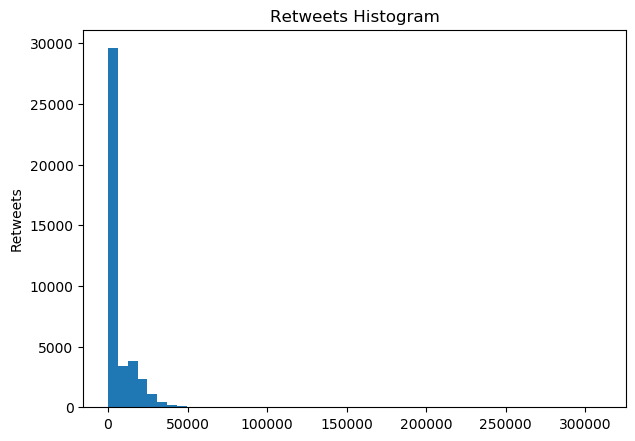

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = df_tweets['retweets']
plt.hist(x, bins=50)
plt.gca().set(title='Retweets Histogram', ylabel='Retweets');

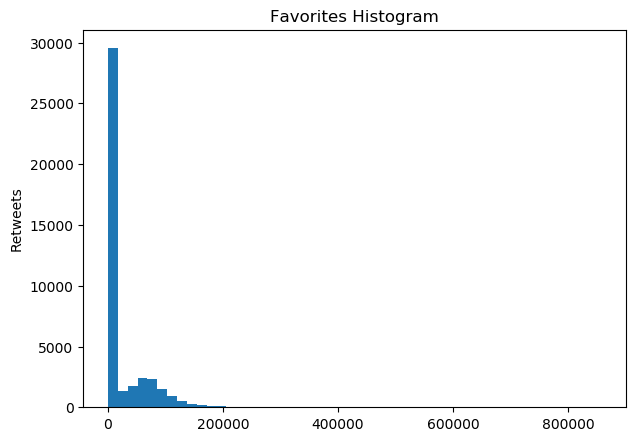

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = df_tweets['favorites']
plt.hist(x, bins=50)
plt.gca().set(title='Favorites Histogram', ylabel='Retweets');